## Analyze A/B Test Results

>Ednalyn C. De Dios<br>
> 7/7/2022<br>
> WGU, Introduction to Data Science - C749

## Table of Contents
- [Part II - Executive Summary](#summary)
- [Part II - Probability](#probability)
- [Part III - A/B Test](#ab_test)
- [Part IV - Regression](#regression)
- [Part V - Conclusion](#conclusions)
- [Part VI - Resources](#resources)

<a id='probability'></a>
#### Part I - Executive Summary
 
The author recommends keeping the current page since there are no statistical evidence that the new page fared better than the current page.

The author used three methods to approach the study. First, simple probability was used to calculate the number of individuals who converted from either one of the groups and were compared. Second, the statistic of z-score and p-values were calculated. And third, logistic regression was used to measure the effect of countries.

All three approaches **failed** to reject the null hypothesis.


<a id='probability'></a>
#### Part II - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
%matplotlib inline

# For reproducibility of results
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
# Get the data
df = pd.read_csv('../data/in/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
round(df['converted'].mean()*100, 2)

11.97

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
treatment_old = df.query("group == 'treatment' and landing_page == 'old_page'").shape[0]
control_new = df.query("group == 'control' and landing_page == 'new_page'").shape[0]
print(treatment_old, control_new)

1965 1928


In [7]:
total_misrouted = treatment_old + control_new
total_misrouted

3893

f. Do any of the rows have missing values?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
# Create a new dataframe before making any changes
df2 = df.copy()

df2.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)
df2.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290585 non-null  int64 
 1   timestamp     290585 non-null  object
 2   group         290585 non-null  object
 3   landing_page  290585 non-null  object
 4   converted     290585 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2['user_id'].duplicated(keep=False)].user_id

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id'].duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates('user_id', inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
round(df2['converted'].mean(), 2)

0.12

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
round(df2.query("group == 'control'")['converted'].mean(), 2)

0.12

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
round(df2.query("group == 'treatment'")['converted'].mean(), 2)

0.12

Let's not round this time for precision.

In [18]:
df2['converted'].mean() - df2.query("group == 'control'")['converted'].mean()

-0.0007892172554649218

d. What is the probability that an individual received the new page?

In [19]:
df2.query("landing_page == 'new_page'").shape[0] / df2['landing_page'].shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The result above shows that the number of individuals who converted from either one of the groups is almost identical. There is no sufficient evidence to conclude that the new treatment page leads to more conversions.**

<a id='ab_test'></a>
### Part III - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$
H_0:p_{old}-p_{new} \ge 0 \\
H_1:p_{old}-p_{new} < 0
$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice([0, 1], size = n_new, p = [p_old, 1 - p_old])
old_page_converted

array([1, 1, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
p_difference = new_page_converted - old_page_converted
p_difference

array([0, 0, 0, ..., 0, 0, 0])

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

> A ValueError occurs when taking the difference between new_page_converted and old_page_converted. Hence, the mean is used instead.

In [27]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [p_new, 1 - p_new]).mean()
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [p_old, 1 - p_old]).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

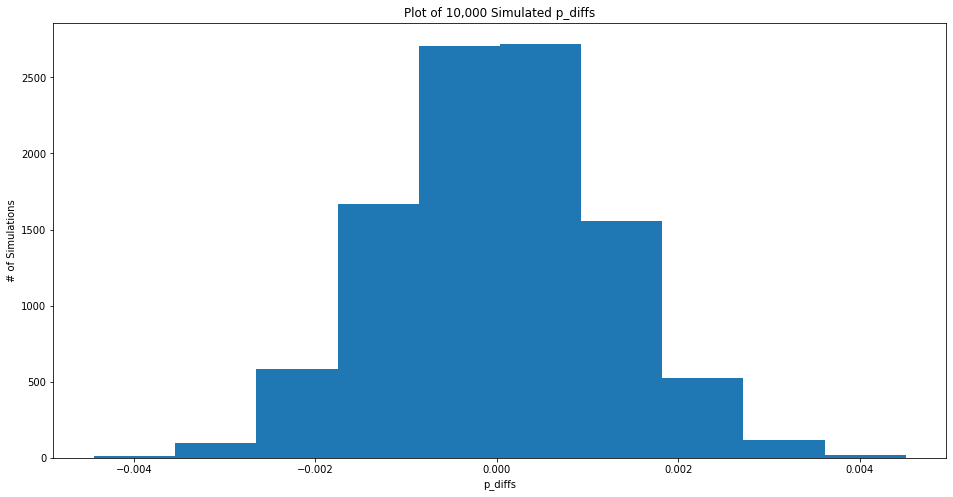

In [28]:
plt.figure(figsize=(16, 8))
plt.hist(p_diffs);
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Plot of 10,000 Simulated p_diffs');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
p_diffs_array = np.array(p_diffs)
p_diffs_array

array([-1.57404737e-03, -7.89379609e-04,  3.80734225e-04, ...,
        7.93572929e-04,  9.87289061e-05,  2.43172343e-03])

In [30]:
actual_diffs = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
actual_diffs

-0.0015782389853555567

In [31]:
(p_diffs > actual_diffs).mean()

0.907

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Above, we were calculating the p-value, "a statistical measurement used to validate a hypothesis against observed data"[1]. It measures the probability of obtaining the observed results,under the assumption that the null hypothesis is true[1]. A p-value of 0.05 is "generally considered statistically significant" and the lower the p-value means the greater the significance of the observed differences.[1] Hence failing to reject the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [33]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old])
z_score, p_value

(-1.3109241984234394, 0.18988337448195103)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Above, the z_score is -1.31 while the p-value is 0.19, which fails to reject the null hypothesis. This result coincides with the results in parts j. and k. which also fails to reject the null hypothesis.**

<a id='regression'></a>
### Part IV - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should be using logistic regression since we are dealing with a binary classification problem of conversion or not.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2[['ab_page2', 'ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('ab_page2', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
# Make the thing (model)
logreg_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
# Fit the thing
results = logreg_model.fit()

# Use the thing
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 07 Jul 2022   Pseudo R-squ.:               8.077e-06
Time:                        09:46:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?

**The p-value here is 0.19 while the value in Part II is 0.90. The difference occurs because the hypothesis of the two parts are not the same.**

Part II:
$$
H_0:p_{old}-p_{new} \ge 0 \\
H_1:p_{old}-p_{new} < 0
$$

Part III:
$$
H_0:p_{old}=p_{new} \\
H_1:p_{old}\neq p_{new}
$$

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to add other factors into the regression model because it may improve the way the model performs. On the other hand, we might experience the curse of dimensionality as we increase the data dimensions.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
# Read in the countries table
df_countries = pd.read_csv('../data/in/countries.csv')

# Merge the two dataframes together
df3 = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
# Number of unique rows in country column.
df3.country.unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
# Add dummy variables
df3[['US', 'CA']] = pd.get_dummies(df3['country'])[['US','CA']]
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [40]:
# Create the thing 2
logreg_model = sm.Logit(df3['converted'], df3[['intercept', 'US', 'CA']])

In [41]:
# Fit the thing 2
results = logreg_model.fit()

# Use the thing 2
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 07 Jul 2022   Pseudo R-squ.:               1.521e-05
Time:                        09:46:24   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
==============================================================================
"""

**Adding country as another feature did not improve the model since both p-values are greater than 0.05. There is no statistical evidence that country affect the conversion rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
# Add dummy variables
df3['US_inter'] = df3['US']*df3['ab_page']
df3['CA_inter'] = df3['CA']*df3['ab_page']

In [43]:
# Create the thing 3
logreg_model = sm.Logit(df3['converted'], df3[['intercept', 'US', 'CA', 'ab_page']])

In [44]:
# Fit the thing 3
results = logreg_model.fit()

# Use the thing 3
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 07 Jul 2022   Pseudo R-squ.:               2.323e-05
Time:                        09:46:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

**Adding ab_page as another feature did not improve the model since all three p-values are greater than 0.05. There is no statistical evidence that pages affect the conversion rate.**

<a id='conclusions'></a>
### Part V - Conclusion

The above sections demonstrate that the new page fares no better than the current page. Therefore, the current page should be kept.

<a id='resources'></a>
## Resources

- [1] https://www.investopedia.com/terms/p/p-value.asp
- [2] https://forketyfork.medium.com/latex-math-formulas-a-cheat-sheet-21e5eca70aae